In [1]:
import pandas as pd 
import numpy as np 

url = "https://raw.githubusercontent.com/alura-cursos/reducao-dimensionalidade/master/data-set/exames.csv"
df = pd.read_csv(url)
df.head(2)

,id,diagnostico,exame_1,exame_2,exame_3,exame_4,exame_5,exame_6,exame_7,exame_8,...,exame_24,exame_25,exame_26,exame_27,exame_28,exame_29,exame_30,exame_31,exame_32,exame_33
0,842302,M,17.99,10.38,122.8,103.78,1001.0,0.11840,0.27760,0.3001,...,184.6,2019.0,0.1622,0.6656,0.7119,0.786,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,103.78,1326.0,0.08474,0.07864,0.0869,...,158.8,1956.0,0.1238,0.1866,0.2416,0.786,0.1860,0.2750,0.08902,NaN


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.random.seed(2)
valores_exames = df.drop(['id','diagnostico'],axis=1)
diagnostico = df['diagnostico']
valores_exames_v1 = valores_exames.drop(['exame_33'],axis=1)
treino_x, teste_x, treino_y,  teste_y = train_test_split(valores_exames_v1,
                                                        diagnostico, test_size=0.3)


modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(treino_x,treino_y)
print("Resultado (RandomForestClassifier - todas as variaveis): ",round(modelo.score(teste_x,teste_y)*100,2),"%")


from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(treino_x,treino_y)
print("Resultado (DummyClassifier): ",round(dummy_model.score(teste_x,teste_y)*100,2),"%")

Resultado (RandomForestClassifier - todas as variaveis):  95.32 %
Resultado (DummyClassifier):  60.82 %


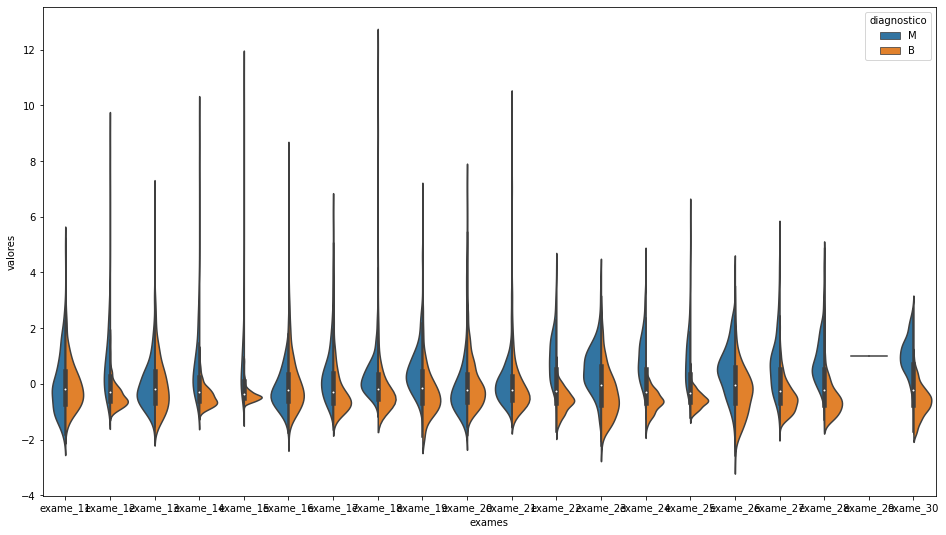

In [48]:
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler


stand = StandardScaler()
valores_exames_v2 = stand.fit_transform(valores_exames_v1)
valores_exames_v2 = pd.DataFrame(data=valores_exames_v2,columns=valores_exames_v1.columns)

def plotar_violino(valores,inicio,fim):
    dados_plot = pd.concat([diagnostico,valores.iloc[:,inicio:fim]],axis=1)
    dados_plot = pd.melt(dados_plot,id_vars='diagnostico',var_name='exames',value_name='valores')
    plt.figure(figsize=(16,9))
    figura = sns.violinplot(x='exames', y='valores', hue='diagnostico',data=dados_plot,split=True)
    #figura.yticks(rotation=90)
    plt.show()
    
plotar_violino(valores_exames_v2,10,30)

In [97]:
valores_exames_v3 = valores_exames_v1.drop(['exame_4','exame_29'],axis=1)

def classificar(valores):
    np.random.seed(2)
    treino_x, teste_x, treino_y,  teste_y = train_test_split(valores,
                                                        diagnostico, test_size=0.3)
    modelo = RandomForestClassifier(n_estimators=100)
    modelo.fit(treino_x,treino_y)
    print("Resultado (RandomForestClassifier): ",round(modelo.score(teste_x,teste_y)*100,2),"%")
classificar(valores_exames_v3)

Resultado (RandomForestClassifier):  94.15 %


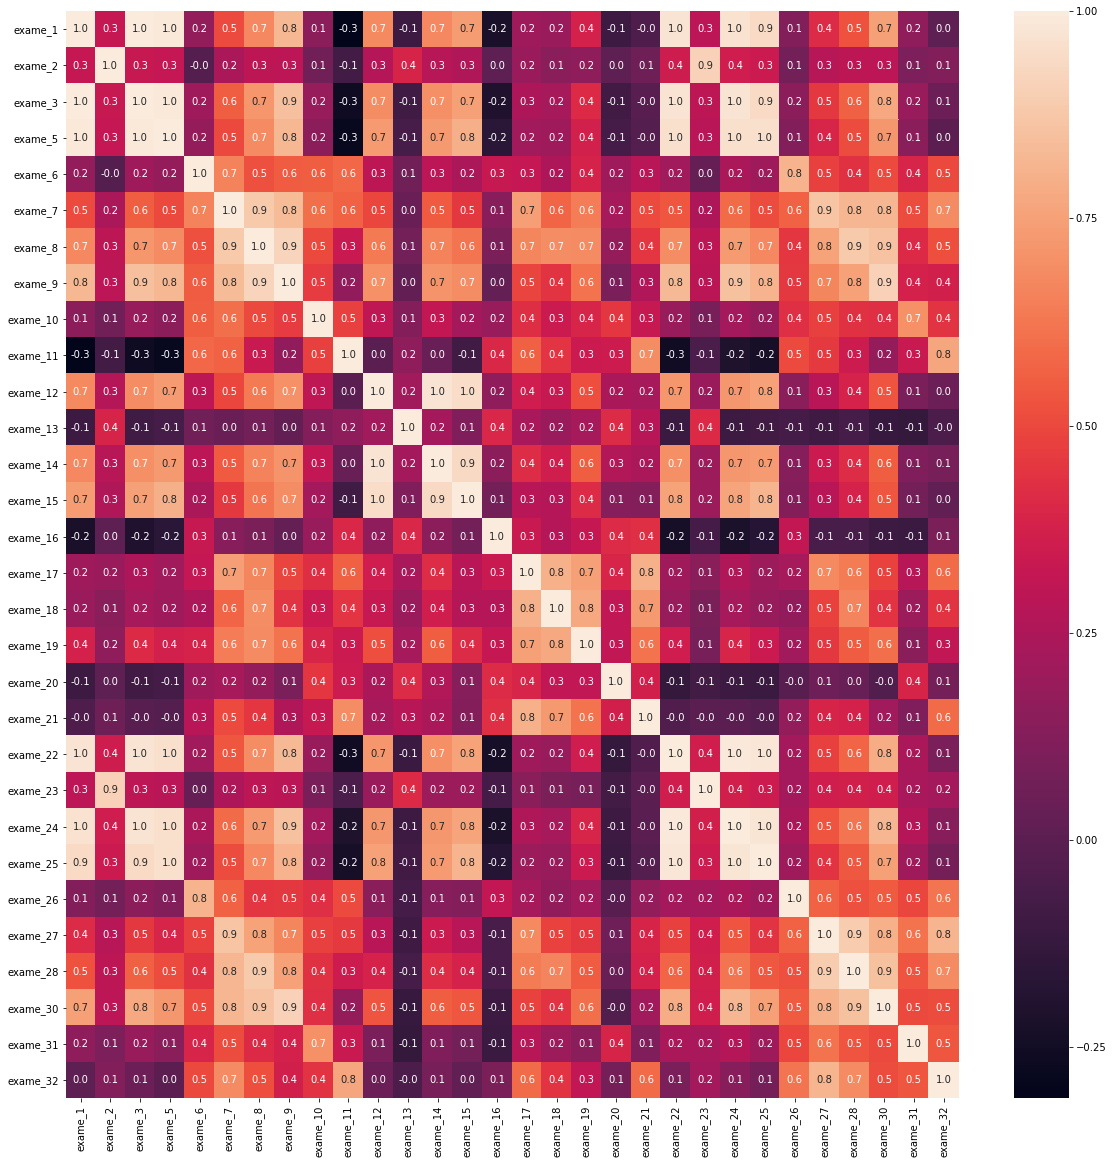

In [98]:
plt.figure(figsize=(20,20))
sns.heatmap(valores_exames_v3.corr(),annot=True,fmt=".1f")

In [99]:
matriz_correlacao = valores_exames_v3.corr()[valores_exames_v3.corr() > 0.99]
matriz_correlacao_v2 = matriz_correlacao.sum()
matriz_correlacao_v3 = matriz_correlacao_v2[matriz_correlacao_v2 > 1]
valores_exames_v4 = valores_exames_v3.drop(matriz_correlacao_v3.drop_duplicates().keys(),axis=1)
classificar(valores_exames_v4)

Resultado (RandomForestClassifier):  94.74 %


In [126]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selecionar_kmelhores = SelectKBest(score_func=chi2,k=5)
treino_x, teste_x, treino_y,  teste_y = train_test_split(valores_exames_v4,
                                                        diagnostico, test_size=0.3)

selecionar_kmelhores.fit(treino_x,treino_y)
treino_x = selecionar_kmelhores.transform(treino_x)
teste_x = selecionar_kmelhores.transform(teste_x)

np.random.seed(2)
modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(treino_x,treino_y)
print("Resultado (RandomForestClassifier -> kbest (5)): ",round(modelo.score(teste_x,teste_y)*100,2),"%")

Resultado (RandomForestClassifier -> kbest (5)):  94.15 %


[Text(30.5, 0.5, 'Real'), Text(0.5, 12.5, 'Predição')]

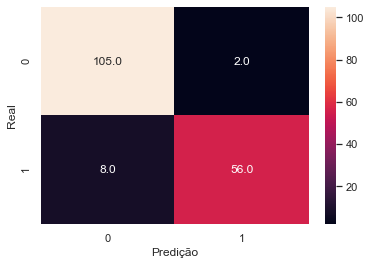

In [134]:
from sklearn.metrics import confusion_matrix

sns.set()
ax = sns.heatmap(confusion_matrix(teste_y,modelo.predict(teste_x)),annot=True, fmt='.1f')
ax.set(xlabel='Predição',ylabel='Real')
# primeiro -> true negatives | second false positives | third false negatives | last true positives,

Resultado (RandomForestClassifier -> RFE (5)):  92.98 %


[Text(30.5, 0.5, 'Real'), Text(0.5, 12.5, 'Predição')]

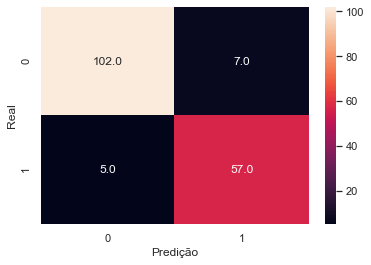

In [139]:
from sklearn.feature_selection import RFE

treino_x, teste_x, treino_y,  teste_y = train_test_split(valores_exames_v4,
                                                        diagnostico, test_size=0.3)
np.random.seed(2)
modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(treino_x,treino_y)

selecionar_rfe = RFE(estimator=modelo, n_features_to_select=5,)
selecionar_rfe.fit(treino_x,treino_y)
treino_x = selecionar_rfe.transform(treino_x)
teste_x = selecionar_rfe.transform(teste_x)
modelo.fit(treino_x,treino_y)

print("Resultado (RandomForestClassifier -> RFE (5)): ",round(modelo.score(teste_x,teste_y)*100,2),"%")

sns.set()
ax = sns.heatmap(confusion_matrix(teste_y,modelo.predict(teste_x)),annot=True, fmt='.1f')
ax.set(xlabel='Predição',ylabel='Real',)

Resultado (RandomForestClassifier -> RFE (5)):  94.74 %


[Text(30.5, 0.5, 'Real'), Text(0.5, 12.5, 'Predição')]

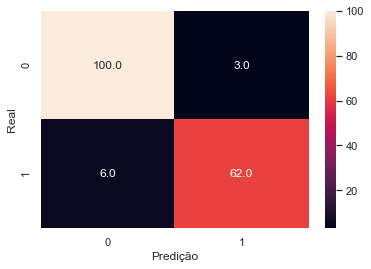

In [147]:
from sklearn.feature_selection import RFECV

treino_x, teste_x, treino_y,  teste_y = train_test_split(valores_exames_v4,
                                                        diagnostico, test_size=0.3)
np.random.seed(2)
modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(treino_x,treino_y)

selecionar_rfe = RFECV(estimator=modelo, min_features_to_select=5, cv=5, scoring='accuracy')
selecionar_rfe.fit(treino_x,treino_y)
treino_x = selecionar_rfe.transform(treino_x)
teste_x = selecionar_rfe.transform(teste_x)
modelo.fit(treino_x,treino_y)

print("Resultado (RandomForestClassifier -> RFE (5)): ",round(modelo.score(teste_x,teste_y)*100,2),"%")

sns.set()
ax = sns.heatmap(confusion_matrix(teste_y,modelo.predict(teste_x)),annot=True, fmt='.1f')
ax.set(xlabel='Predição',ylabel='Real',)

Número de melhores features: 15
Index(['exame_2', 'exame_3', 'exame_5', 'exame_8', 'exame_9', 'exame_12',
       'exame_15', 'exame_23', 'exame_24', 'exame_25', 'exame_26', 'exame_27',
       'exame_28', 'exame_30', 'exame_31'],
      dtype='object')


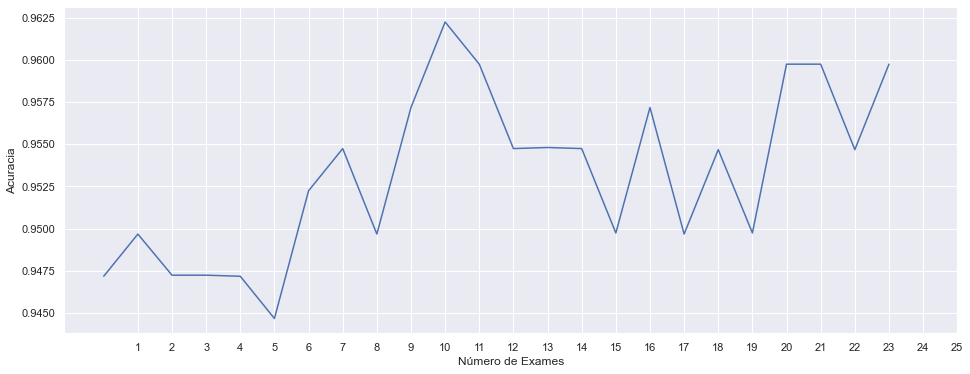

In [158]:
print("Número de melhores features:",selecionar_rfe.n_features_)
print(valores_exames_v4.columns[selecionar_rfe.support_])

plt.figure(figsize=(16,6))
plt.xlabel("Número de Exames")
plt.ylabel("Acuracia")
plt.plot(selecionar_rfe.grid_scores_)
plt.xticks(range(1,len(selecionar_rfe.grid_scores_)+2))
#plt.grid()
plt.show()

Resultado (RandomForestClassifier -> RFE (2)):  94.15 %


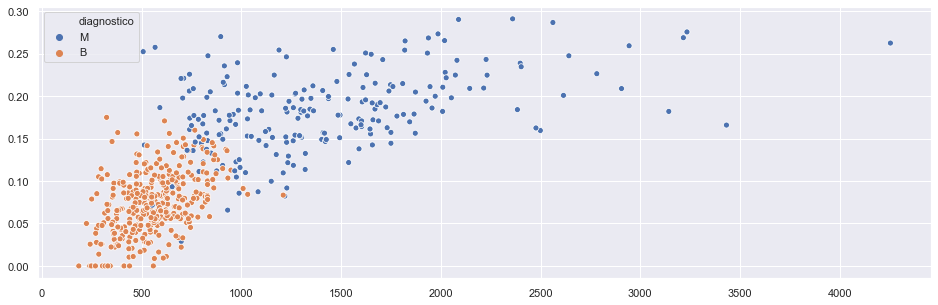

In [161]:
from sklearn.feature_selection import RFE

treino_x, teste_x, treino_y,  teste_y = train_test_split(valores_exames_v4,
                                                        diagnostico, test_size=0.3)
np.random.seed(2)
modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(treino_x,treino_y)

selecionar_rfe = RFE(estimator=modelo, n_features_to_select=2)
selecionar_rfe.fit(treino_x,treino_y)
treino_x = selecionar_rfe.transform(treino_x)
teste_x = selecionar_rfe.transform(teste_x)
modelo.fit(treino_x,treino_y)
valores_exames_v5 = selecionar_rfe.transform(valores_exames_v4)
print("Resultado (RandomForestClassifier -> RFE (2)): ",round(modelo.score(teste_x,teste_y)*100,2),"%")
plt.figure(figsize=(16,5))
sns.scatterplot(x=valores_exames_v5[:,0],y=valores_exames_v5[:,1],hue=diagnostico)

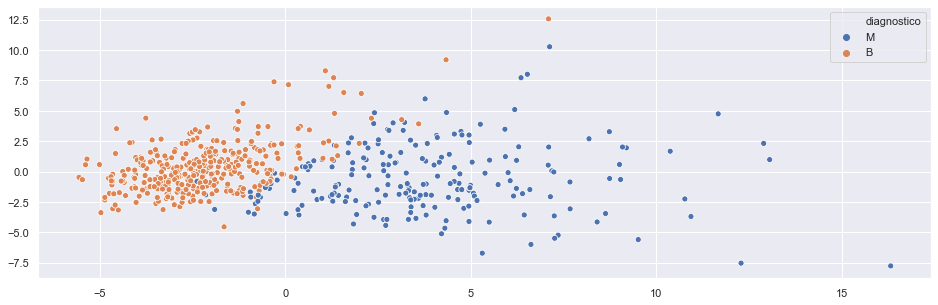

In [164]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
valores_exames_v6 = pca.fit_transform(valores_exames_v2)
plt.figure(figsize=(16,5))
sns.scatterplot(x=valores_exames_v6[:,0],y=valores_exames_v6[:,1],hue=diagnostico)

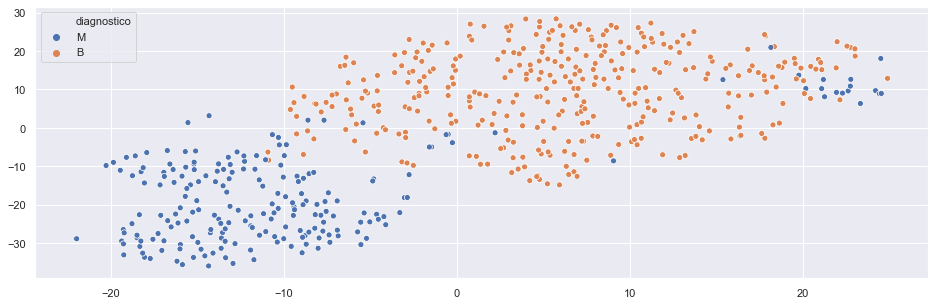

In [169]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
valores_exames_v6 = tsne.fit_transform(valores_exames_v2)
plt.figure(figsize=(16,5))
sns.scatterplot(x=valores_exames_v6[:,0],y=valores_exames_v6[:,1],hue=diagnostico)